In [1]:
!pip install git+https://github.com/huggingface/transformers.git -qqq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install torchmetrics -qqq

In [40]:
import os
import re
import cv2
import requests
import math
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torchvision
from torchvision.ops import distance_box_iou_loss
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from transformers import AutoModel, AutoTokenizer, get_scheduler
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torchmetrics.detection import IntersectionOverUnion,MeanAveragePrecision
from transformers.image_utils import load_image

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dinov3")

In [5]:
ds = load_dataset("jxu124/refcoco")
columns_to_keep = ["file_name", "raw_sentences", "bbox"]
ds = ds.select_columns(columns_to_keep)

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['file_name', 'raw_sentences', 'bbox'],
        num_rows: 42404
    })
    validation: Dataset({
        features: ['file_name', 'raw_sentences', 'bbox'],
        num_rows: 3811
    })
    test: Dataset({
        features: ['file_name', 'raw_sentences', 'bbox'],
        num_rows: 1975
    })
    testB: Dataset({
        features: ['file_name', 'raw_sentences', 'bbox'],
        num_rows: 1810
    })
})

In [7]:
train = ds['train']
val = ds['validation']
test  = concatenate_datasets([ds['test'], ds['testB']])

In [8]:
train[0]

{'file_name': 'COCO_train2014_000000581857_16.jpg',
 'raw_sentences': '[{"tokens": ["the", "lady", "with", "the", "blue", "shirt"], "raw": "THE LADY WITH THE BLUE SHIRT", "sent_id": 0, "sent": "the lady with the blue shirt"}, {"tokens": ["lady", "with", "back", "to", "us"], "raw": "lady w back to us", "sent_id": 1, "sent": "lady with back to us"}, {"tokens": ["blue", "shirt"], "raw": "blue shirt", "sent_id": 2, "sent": "blue shirt"}]',
 'bbox': [103.93, 299.99, 238.15, 477.40999999999997]}

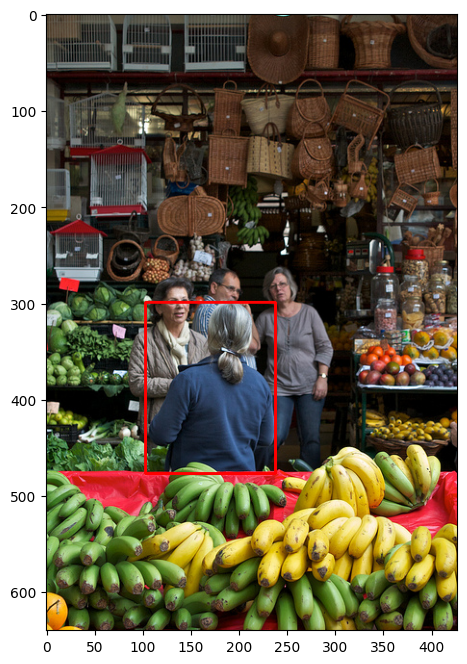

In [9]:
img_path = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014'
img_file = os.path.join(img_path, 'COCO_train2014_000000581857.jpg')

img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

x_min, y_min, x_max, y_max = train[0]['bbox']
cv2.rectangle(img, 
              (int(x_min), int(y_min)), 
              (int(x_max), int(y_max)), 
              color=(255, 0, 0),  
              thickness=2)

plt.figure(figsize=(8,8))
plt.imshow(img)

In [10]:
IMG_SIZE = 224
transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

class GroundingDataset(Dataset):
    def __init__(self, ds, img_path, transform=None):
        self.ds = []
        for sample in ds:
            sentences = re.findall(r'"sent":\s*"([^"]+)"', sample['raw_sentences'])
            for s in sentences:
                self.ds.append({
                    'img': sample['file_name'],
                    'sent': s,
                    'bbox': sample['bbox']   
                })
        
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        sample = self.ds[idx]
        fname = re.findall(r'(\w*\d*)(?:_.*)', sample['img'])[0] + '.jpg'
        path = os.path.join(self.img_path, fname)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        bbox = sample['bbox']
        label = 1  

        if self.transform:
            transformed = self.transform(image=img, bboxes=[bbox], labels=[label])
            img = transformed['image']            
            bbox = transformed['bboxes'][0]    
            bbox = [coord / IMG_SIZE for coord in bbox]

        return {
            'pixel_values': img,            
            'sent': sample['sent'], 
            'bbox': bbox,                 
        }


In [11]:
trainset = GroundingDataset(train,img_path,transforms)
valset = GroundingDataset(val,img_path,transforms)
testset = GroundingDataset(test,img_path,transforms)

In [12]:
trainset[0]

{'pixel_values': tensor([[[-0.6281, -0.5767, -0.7137,  ..., -1.2617, -1.3302, -1.3815],
          [-0.5938, -0.6623, -0.7993,  ..., -1.1247, -1.2445, -1.1075],
          [-0.5596, -0.6109, -0.6965,  ..., -0.9534, -1.0390, -0.9534],
          ...,
          [ 1.2214,  0.9988,  1.3242,  ..., -0.1999, -0.9534, -1.4500],
          [ 2.2147,  1.9578,  1.0844,  ..., -0.6281, -1.5528, -1.5870],
          [ 2.2147,  2.2147,  2.2147,  ..., -1.6213, -1.7412, -1.7754]],
 
         [[-0.7052, -0.7227, -0.8627,  ..., -1.5105, -1.5630, -1.5980],
          [-0.7227, -0.7577, -0.9153,  ..., -1.3880, -1.4930, -1.3529],
          [-0.6176, -0.7227, -0.8452,  ..., -1.2304, -1.3179, -1.2304],
          ...,
          [-0.0399, -0.3725, -0.2325,  ...,  0.2577, -1.2479, -1.8606],
          [ 1.5532,  1.0105, -0.4776,  ..., -0.7752, -1.8782, -1.8431],
          [ 1.5007,  1.4657,  1.5357,  ..., -1.9132, -1.9657, -1.9482]],
 
         [[-0.7936, -0.7413, -0.9156,  ..., -1.4733, -1.5256, -1.5779],
          [-

In [13]:
print('Train Samples:',len(trainset))
print('Val Samples:',len(valset))
print('Test Samples:',len(testset))

Train Samples: 120624
Val Samples: 10834
Test Samples: 10752


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
img_model = AutoModel.from_pretrained("facebook/dinov3-vitb16-pretrain-lvd1689m",token=secret_value_0)
for param in img_model.parameters():
    param.requires_grad = False

In [16]:
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
text_model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5").to(device)
for param in text_model.parameters():
    param.requires_grad = False

In [17]:
def collate_fn(batch):
    images = torch.stack([data['pixel_values'] for data in batch]) 
    sentences = [data['sent'] for data in batch]
    bboxes = torch.tensor([data['bbox'] for data in batch])

    encoded = tokenizer(
        sentences,
        padding='longest',            
        truncation=True,         
        return_tensors='pt'
    )

    return {
        'pixel_values': images,
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'bboxes': bboxes
    }


trainloader = DataLoader(trainset,batch_size=32,shuffle=True,collate_fn=collate_fn)
valloader = DataLoader(valset,batch_size=32,shuffle=False,collate_fn=collate_fn)
testloader = DataLoader(testset,batch_size=32,shuffle=False,collate_fn=collate_fn)

In [18]:
DIM = 512
config = nn.TransformerDecoderLayer(
    d_model=DIM,
    nhead=8,
    dim_feedforward=2048,
    dropout=0.1,
    activation='gelu',
    batch_first=True
)
decoder = nn.TransformerDecoder(config, num_layers=6).to(device)

In [19]:
class GroundingModel(nn.Module):
    def __init__(self, img_model, text_model, decoder, d_model):
        super().__init__()
        self.img_model = img_model
        self.text_model = text_model
        self.decoder = decoder

        self.img_proj = nn.Linear(img_model.config.hidden_size, d_model)
        self.text_proj = nn.Linear(text_model.config.hidden_size, d_model)

        self.bbox_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 4),
            nn.Sigmoid() 
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        img_outputs = self.img_model(pixel_values=pixel_values)
        iemb = img_outputs.last_hidden_state         
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        temb = text_outputs.last_hidden_state        

        iemb_proj = self.img_proj(iemb)            
        temb_proj = self.text_proj(temb)             

        tgt_key_padding_mask = (attention_mask == 0)  

        fusion = self.decoder(tgt=temb_proj, memory=iemb_proj, tgt_key_padding_mask=tgt_key_padding_mask)
        cls_token_output = fusion.mean(dim=1)         
        out = self.bbox_head(cls_token_output)       
        return out

In [20]:
model = GroundingModel(img_model,text_model,decoder,DIM).to(device)

In [21]:
model

GroundingModel(
  (img_model): DINOv3ViTModel(
    (embeddings): DINOv3ViTEmbeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (rope_embeddings): DINOv3ViTRopePositionEmbedding()
    (layer): ModuleList(
      (0-11): 12 x DINOv3ViTLayer(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): DINOv3ViTAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (o_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_scale1): DINOv3ViTLayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): DINOv3ViTMLP(
          (up_proj): Linear(in_features=768, out_features=3072, bias=True)
          (down_proj): Linear(in_features=30

In [22]:
print(f'Total Params: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable Params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Total Params: 144,968,836
Trainable Params: 25,948,420


In [23]:
batch_size = 2
dummy_img = torch.randn(batch_size, 3, 224, 224).to(device)
dummy_input_ids = torch.randint(0, 1000, (batch_size, 10)).to(device)
dummy_attention = torch.ones(batch_size, 10, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    preds = model(pixel_values=dummy_img, input_ids=dummy_input_ids, attention_mask=dummy_attention)
    print("dummy preds shape:", preds.shape)

dummy preds shape: torch.Size([2, 4])


In [24]:
def format_for_iou(preds, targets):
    preds_unscaled = preds.clone() * IMG_SIZE
    targets_unscaled = targets.clone() * IMG_SIZE

    preds_list = [
        {
            "boxes": box.unsqueeze(0),
            "scores": torch.tensor([1.0], device=box.device),
            "labels": torch.tensor([0], device=box.device),
        }
        for box in preds_unscaled
    ]
    targets_list = [
        {
            "boxes": box.unsqueeze(0),
            "labels": torch.tensor([0], device=box.device),
        }
        for box in targets_unscaled
    ]
    return preds_list, targets_list

In [25]:
num_epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3, betas=(0.99, 0.999))
total_training_steps = num_epochs * len(trainloader)
scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=int(0.05 * total_training_steps),
    num_training_steps=total_training_steps
)
train_iou_metric = IntersectionOverUnion(box_format='xyxy').to(device)
val_iou_metric = IntersectionOverUnion(box_format='xyxy').to(device)
best_val_iou = 0

In [26]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_iou_metric.reset() 
    running_loss = 0.0

    pbar = tqdm(trainloader, desc=f"Train Epoch {epoch}/{num_epochs}")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device, dtype=torch.float32)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        bboxes = batch['bboxes'].to(device, dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)

        preds_unscaled = preds * IMG_SIZE
        bboxes_unscaled = bboxes * IMG_SIZE
        loss = distance_box_iou_loss(preds_unscaled, bboxes_unscaled, reduction='mean')
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * pixel_values.size(0)
        
        preds_fmt, bboxes_fmt = format_for_iou(preds.detach(), bboxes)
        train_iou_metric.update(preds_fmt, bboxes_fmt)
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = running_loss / len(trainloader.dataset)
    epoch_train_iou = train_iou_metric.compute()['iou']
    print(f"Epoch {epoch} ==> Train Loss: {avg_train_loss:.6f}, Train IoU: {epoch_train_iou:.6f}")

    # --- VALIDATION ---
    if valloader is not None:
        model.eval()
        val_iou_metric.reset()
        val_loss_accum = 0.0

        with torch.no_grad():
            for batch in tqdm(valloader, desc="Validation", leave=False):
                pixel_values = batch['pixel_values'].to(device, dtype=torch.float32)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                bboxes = batch['bboxes'].to(device, dtype=torch.float32)

                preds = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
                
                preds_unscaled = preds * IMG_SIZE
                bboxes_unscaled = bboxes * IMG_SIZE
                loss = distance_box_iou_loss(preds_unscaled, bboxes_unscaled, reduction='mean')
                
                val_loss_accum += loss.item() * pixel_values.size(0)

                preds_fmt, bboxes_fmt = format_for_iou(preds.detach(), bboxes)
                val_iou_metric.update(preds_fmt, bboxes_fmt)

        avg_val_loss = val_loss_accum / len(valloader.dataset)
        val_iou = val_iou_metric.compute()['iou'] 
        
        print(f"Epoch {epoch} ==> VAL Loss: {avg_val_loss:.6f} | VAL IoU: {val_iou:.6f}")

        # --- Checkpointing ---
        os.makedirs("checkpoints", exist_ok=True)
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            ckpt_path = os.path.join("checkpoints", f"best_model_iou.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"Saved new best model to: {ckpt_path} (IoU: {best_val_iou:.4f})")

### Train Results 

| Epoch | Train Loss | Train IoU | Val Loss | Val IoU |
|-------|------------|-----------|----------|---------|
| 1     | 0.6769     | 0.3658    | 0.6040   | 0.4308  |
| 2     | 0.5558     | 0.4791    | 0.5361   | 0.4991  |
| 3     | 0.5027     | 0.5302    | 0.5003   | 0.5329  |
| 4     | 0.4678     | 0.5628    | 0.4795   | 0.5525  |
| 5     | 0.4392     | 0.5892    | 0.4518   | 0.5778  |
| 6     | 0.4104     | 0.6155    | 0.4352   | 0.5940  |
| 7     | 0.3856     | 0.6380    | 0.4212   | 0.6065  |
| 8     | 0.3655     | 0.6562    | 0.4093   | 0.6174  |
| 9     | 0.3509     | 0.6696    | 0.4065   | 0.6197  |
| 10    | 0.3440     | 0.6759    | 0.4056   | 0.6205  |


In [27]:
inf_model_path = r'/kaggle/input/best_obj_detector/pytorch/default/1/checkpoints/best_model_iou.pt'
inf_model = GroundingModel(img_model, text_model, decoder, DIM).to(device)
inf_model.load_state_dict(torch.load(inf_model_path, map_location=device))
inf_model = inf_model.eval()
print(f"Model loaded successfully from {inf_model_path}")

Model loaded successfully from /kaggle/input/best_obj_detector/pytorch/default/1/checkpoints/best_model_iou.pt


In [28]:
test_iou_metric = IntersectionOverUnion(box_format='xyxy').to(device)
test_map_metric = MeanAveragePrecision(box_format='xyxy').to(device)

In [29]:
with torch.no_grad():
    for batch in tqdm(testloader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device, dtype=torch.float32)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        bboxes = batch['bboxes'].to(device, dtype=torch.float32)

        preds = inf_model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)

        preds_fmt, bboxes_fmt = format_for_iou(preds.detach(), bboxes)

        test_iou_metric.update(preds_fmt, bboxes_fmt)
        test_map_metric.update(preds_fmt, bboxes_fmt)

Testing:   0%|          | 0/336 [00:00<?, ?it/s]

In [33]:
test_iou_results = test_iou_metric.compute()
test_map_results = test_map_metric.compute()

print("\n--- Test Results ---")
print(f"Mean IoU (mIoU): {test_iou_results['iou']:.4f}")

print("\n--- Mean Average Precision (MAP) ---")
print(f"mAP@50: {test_map_results['map_50'].item():.4f}")
print(f"mAP@75: {test_map_results['map_75'].item():.4f}")


--- Test Results ---
Mean IoU (mIoU): 0.6196

--- Mean Average Precision (MAP) ---
mAP@50: 0.5746
mAP@75: 0.2173


In [46]:
def predict_and_crop(image_url, text_prompt, model, tokenizer, transforms, device):
    print(f"Processing prompt: '{text_prompt}'")
    try:
        original_image = load_image(image_url).convert("RGB")
        original_w, original_h = original_image.size
        image_np = np.array(original_image)
        transformed = transforms(image=image_np, bboxes=[[0,0,1,1]], labels=[1])
        pixel_values = transformed['image'].unsqueeze(0).to(device) 

        encoded_text = tokenizer(
            text_prompt,
            padding='longest',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)

        with torch.no_grad():
            prediction = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask
            )
    
        pred_box_normalized = prediction.squeeze(0).cpu().numpy()
        xmin_norm, ymin_norm, xmax_norm, ymax_norm = pred_box_normalized
        
        pred_box = [
            int(xmin_norm * original_w),
            int(ymin_norm * original_h),
            int(xmax_norm * original_w),
            int(ymax_norm * original_h)
        ]

        print(f"Predicted BBox (scaled): {pred_box}")

        cropped_image = original_image.crop(pred_box)
        
        img_with_box = np.array(original_image).copy()
        cv2.rectangle(
            img_with_box,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            color=(255, 0, 0),
            thickness=2
        )
        
        return cropped_image, pred_box, Image.fromarray(img_with_box)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return None, None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

Processing prompt: 'the cat on the sofa'
Predicted BBox (scaled): [12, 225, 649, 546]


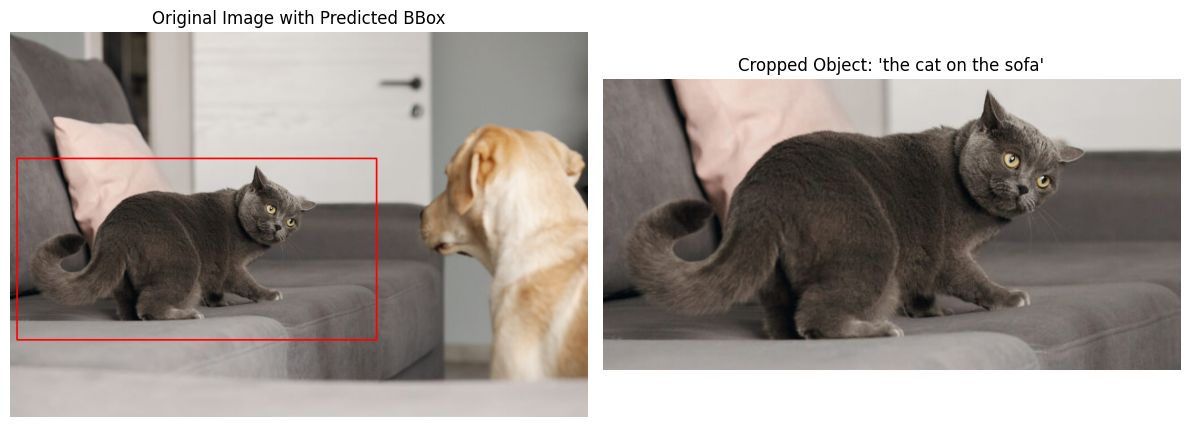

In [47]:
image_url = "https://bouldervet.com/wp-content/uploads/2023/09/dog-cat-coexistence-1024x683.jpg"
prompt = "the cat on the sofa"
cropped_object, box, image_with_box = predict_and_crop(image_url, prompt, inf_model, tokenizer, transforms, device)
if cropped_object:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_box)
    axes[0].set_title("Original Image with Predicted BBox")
    axes[0].axis('off')

    axes[1].imshow(cropped_object)
    axes[1].set_title(f"Cropped Object: '{prompt}'")
    axes[1].axis('off')

    plt.tight_layout()

Processing prompt: 'cycle in the ground'
Predicted BBox (scaled): [206, 1750, 1578, 2783]


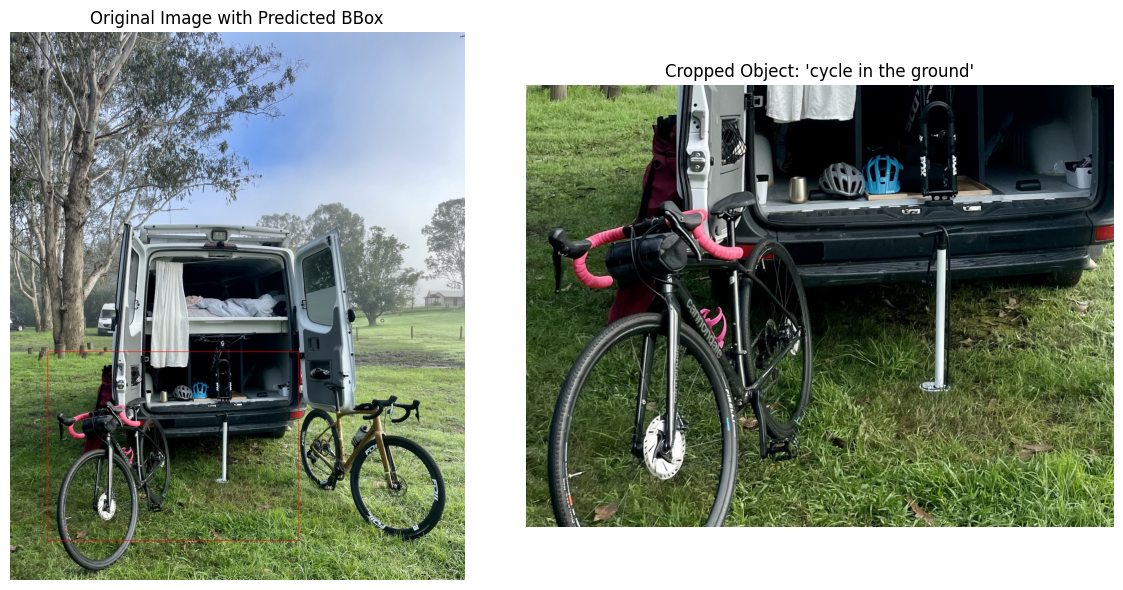

In [48]:
image_url = "https://bicyclingaustralia.com.au/wp-content/uploads/2022/06/44C82760-91BB-4FEC-B3DC-694551F53776.jpeg"
prompt = "cycle in the ground"
cropped_object, box, image_with_box = predict_and_crop(image_url, prompt, inf_model, tokenizer, transforms, device)
if cropped_object:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_box)
    axes[0].set_title("Original Image with Predicted BBox")
    axes[0].axis('off')

    axes[1].imshow(cropped_object)
    axes[1].set_title(f"Cropped Object: '{prompt}'")
    axes[1].axis('off')

    plt.tight_layout()

Processing prompt: 'a Van with door wide open'
Predicted BBox (scaled): [471, 1197, 1773, 2231]


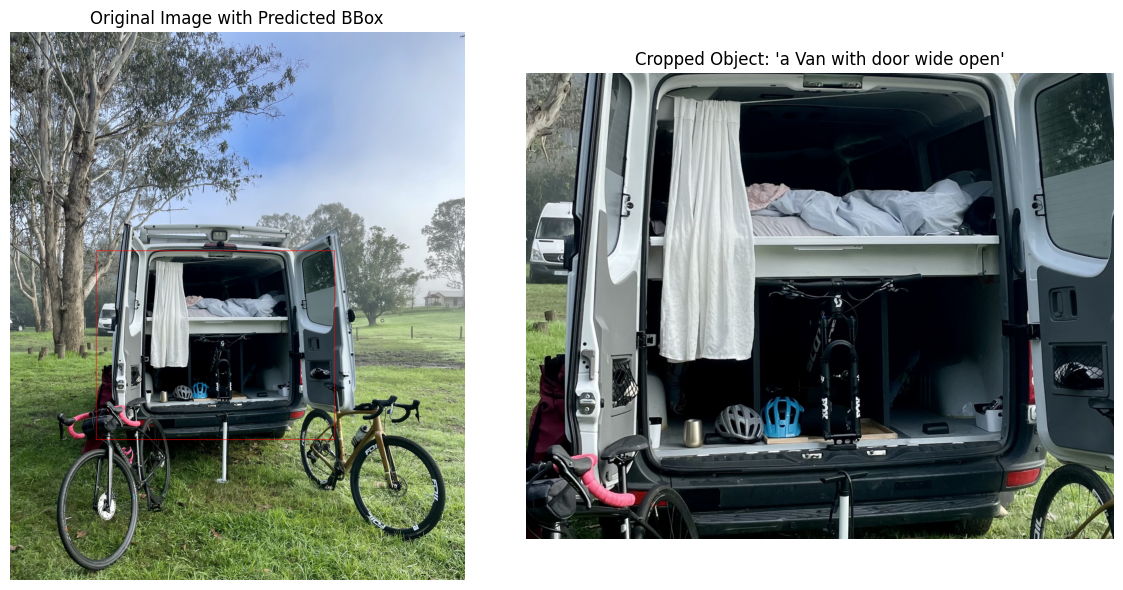

In [49]:
image_url = "https://bicyclingaustralia.com.au/wp-content/uploads/2022/06/44C82760-91BB-4FEC-B3DC-694551F53776.jpeg"
prompt = "a Van with door wide open"
cropped_object, box, image_with_box = predict_and_crop(image_url, prompt, inf_model, tokenizer, transforms, device)
if cropped_object:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_box)
    axes[0].set_title("Original Image with Predicted BBox")
    axes[0].axis('off')

    axes[1].imshow(cropped_object)
    axes[1].set_title(f"Cropped Object: '{prompt}'")
    axes[1].axis('off')

    plt.tight_layout()

Processing prompt: 'the tiger hunting'
Predicted BBox (scaled): [157, 206, 365, 343]


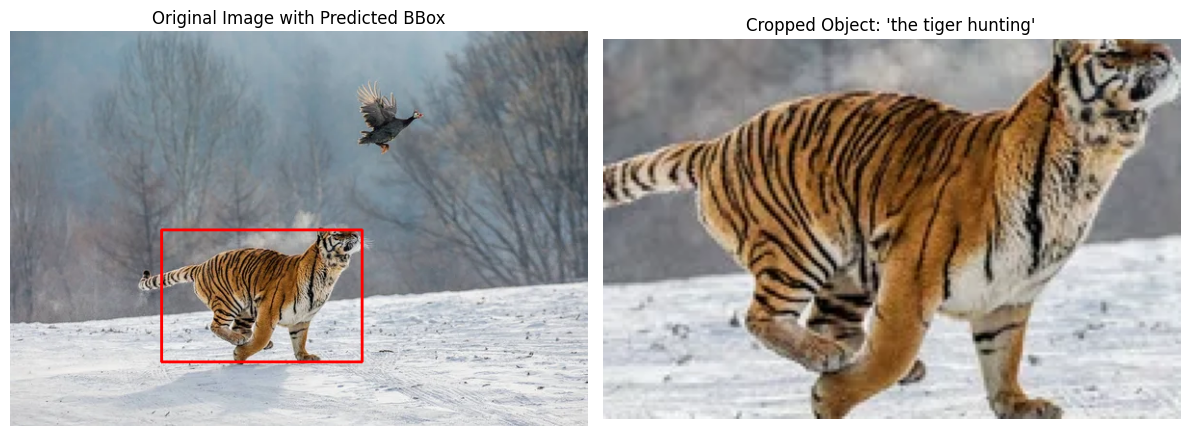

In [51]:
image_url = "https://st4.depositphotos.com/4507459/25233/i/450/depositphotos_252335420-stock-photo-siberian-tiger-chasing-flying-prey.jpg"
prompt = "the tiger hunting"
cropped_object, box, image_with_box = predict_and_crop(image_url, prompt, inf_model, tokenizer, transforms, device)
if cropped_object:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_box)
    axes[0].set_title("Original Image with Predicted BBox")
    axes[0].axis('off')

    axes[1].imshow(cropped_object)
    axes[1].set_title(f"Cropped Object: '{prompt}'")
    axes[1].axis('off')

    plt.tight_layout()

Processing prompt: 'buildings'
Predicted BBox (scaled): [241, 50, 745, 518]


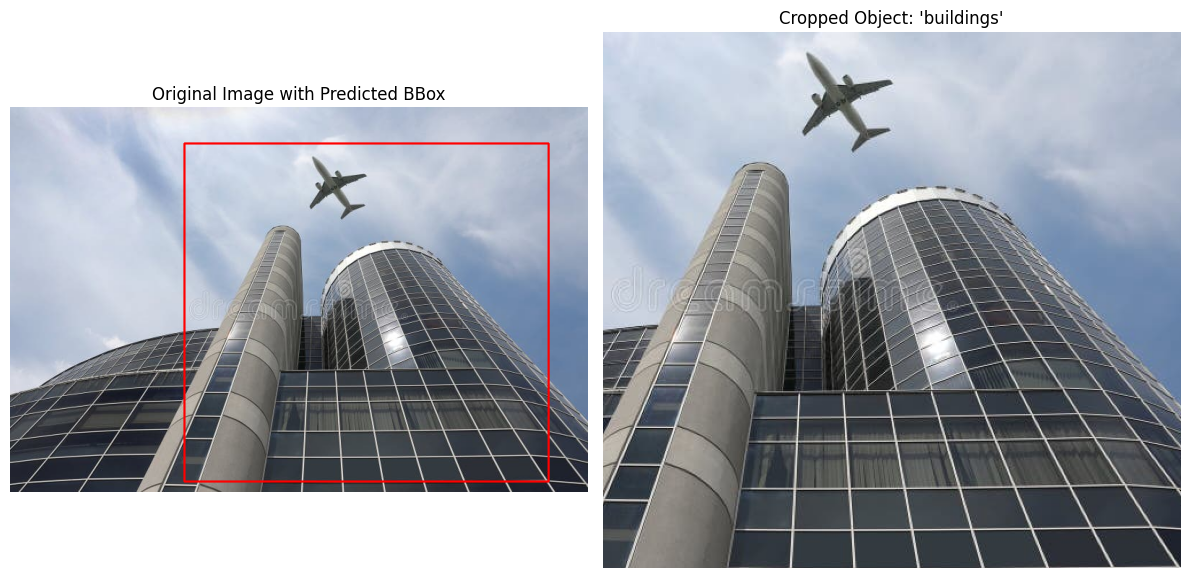

In [54]:
image_url = "https://thumbs.dreamstime.com/b/airplane-flying-over-building-city-low-angle-view-391335754.jpg"
prompt = "buildings"
cropped_object, box, image_with_box = predict_and_crop(image_url, prompt, inf_model, tokenizer, transforms, device)
if cropped_object:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_box)
    axes[0].set_title("Original Image with Predicted BBox")
    axes[0].axis('off')

    axes[1].imshow(cropped_object)
    axes[1].set_title(f"Cropped Object: '{prompt}'")
    axes[1].axis('off')

    plt.tight_layout()

Processing prompt: 'an aeroplane flying above building'
Predicted BBox (scaled): [343, 50, 618, 240]


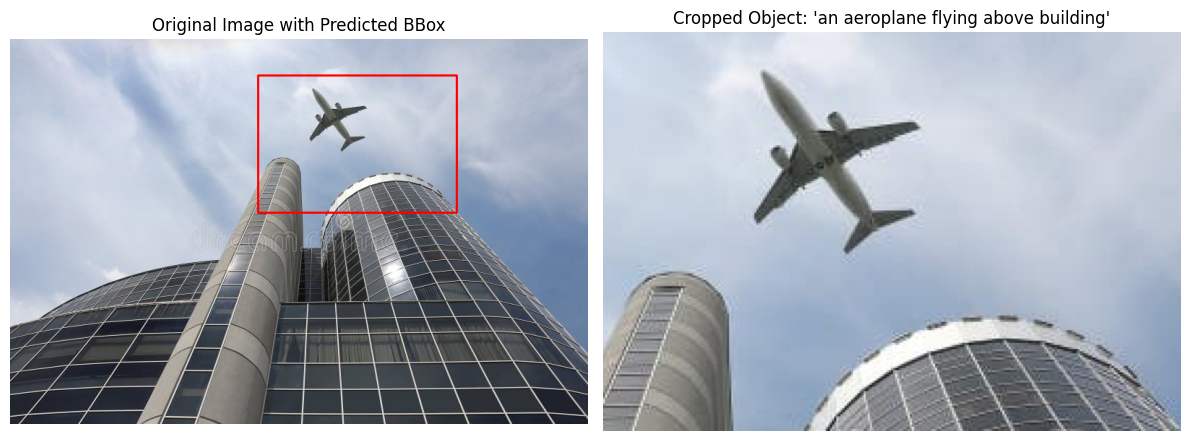

In [56]:
image_url = "https://thumbs.dreamstime.com/b/airplane-flying-over-building-city-low-angle-view-391335754.jpg"
prompt = "an aeroplane flying above building"
cropped_object, box, image_with_box = predict_and_crop(image_url, prompt, inf_model, tokenizer, transforms, device)
if cropped_object:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_box)
    axes[0].set_title("Original Image with Predicted BBox")
    axes[0].axis('off')

    axes[1].imshow(cropped_object)
    axes[1].set_title(f"Cropped Object: '{prompt}'")
    axes[1].axis('off')

    plt.tight_layout()